# Figure 3B, synthetic data

In [1]:
%load_ext autoreload 
%autoreload 2
from utils.prediction_models import *

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['figure.dpi'] = 200

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")

# Generate synthetic data

In [ ]:
# Modify the simulated data logic to support parathesis

import random
class BinaryLogicTree:
    def __init__(self):
        self.is_leaf=False
        self.left, self.right=None, None
        self.name=''

    def __str__(self):
        """ Intepretable logic string"""
        if self.is_leaf:
            return str(self.name)
        left_str=str(self.left)
        if not self.left.is_leaf:
            left_str=f'({left_str})'
        right_str=str(self.right)
        if not self.right.is_leaf:
            right_str=f'({right_str})'
       
        return f'{left_str}{self.name}{right_str}'

    def to_newick(self):
        """ Newick format string"""
        if self.is_leaf:
            return self.name
        else:
            return f'({self.left.to_newick()},{self.right.to_newick()}):{self.name}'

    def random_populate(self, leaves, min_split_ratio=None,p_and=None):
        leaves=np.unique(leaves).astype(str)
        if len(leaves)==1:
            self.is_leaf=True
            self.name=leaves[0]
            self._need_parathesis=False
            return self
        
        if min_split_ratio is None:
            min_n_leaves=1
        elif min_split_ratio>=0.5:
            raise ValueError
        else:
            min_n_leaves=int(len(leaves)*min_split_ratio)
        min_n_leaves=max(1,min_n_leaves)
        n_left=random.randint(min_n_leaves, len(leaves)-min_n_leaves)
        left_leaves=np.random.choice(leaves, n_left,replace=False)
        right_leaves=np.setdiff1d(leaves, left_leaves)

        left_tree=BinaryLogicTree()
        left_tree.random_populate(left_leaves, min_split_ratio=min_split_ratio,p_and=p_and)
        right_tree=BinaryLogicTree()
        right_tree.random_populate(right_leaves, min_split_ratio=min_split_ratio,p_and=p_and)

        self.left=left_tree
        self.right=right_tree
        self._is_leaf=False
        if p_and is None:
            p=None
        else:
            p=[p_and,1-p_and]
        self.name=np.random.choice(['&', '|'], p=p)
    
    def calculate(self, value_map):
        if self.is_leaf:
            return value_map[self.name]
        else:
            if self.name=='&':
                return self.left.calculate(value_map) and self.right.calculate(value_map)
            elif self.name=='|':
                return self.left.calculate(value_map) or self.right.calculate(value_map)
            else:
                raise ValueError


In [ ]:
ko_data,growth_data,samples,carbons,tree=bacdive['ko_data'],bacdive['growth_data'],bacdive['samples'],bacdive['carbons'],bacdive['tree']

n_traits=100
min_zeros_ratio, min_ones_ratio=0.1,0.1

parameter_space=[]
for n_samples in [ko_data.shape[0], 1000,500, 250,100]:
    for n_total_features in [ko_data.shape[1], 2000,500,300,100]:
        for n_true_features in [3,10,30,100,300]:
            for min_split_ratio in [0, 0.3]:
                if n_true_features<=n_total_features:
                    parameter_space.append((n_samples,n_total_features,n_true_features, min_split_ratio))

In [ ]:
# Generate simulated data

DIR_synthetic_data=f"{DIR_data}/figure_data/3B/synthetic_data"


def finalize_data(ko_data, growth_data, tree,remove_prefix=False):    
    # Copied from organize_data.ipynb
    samples=np.intersect1d(ko_data.index,growth_data.index)
    tree_samples=[leaf.name for leaf in tree.get_leaves()]
    tree=tree.copy()
    if remove_prefix and remove_prefix is not None:
        for leaf in tree.get_leaves():
            leaf.name=leaf.name.replace("matti_","").replace("zeqian_","").replace("bacdive_","")
    
    samples=np.intersect1d(samples,[node.name for node in tree.get_leaves()])
    # print(f"{len(samples)} samples: ", samples)

    ko_data=ko_data.loc[samples]
    growth_data=growth_data.loc[samples]
    tree.prune(samples, preserve_branch_length=True)
    return {'ko_data':ko_data, 'growth_data':growth_data,'tree':tree,'samples': samples, 'carbons':growth_data.columns.values}



for n_samples, n_total_features, n_true_features,min_split_ratio in tqdm(parameter_space,desc="Generating simulated data"):

    ff_out=os.path.join(DIR_synthetic_data,f"{n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio}.pk")
    if os.path.exists(ff_out):
        print("File exists, skipping")
        continue

    X=ko_data.copy()

    # Subsample X  
    if n_samples is not None and n_samples < X.shape[0]:
        samples=np.random.choice(X.index.values, n_samples, replace=False)
        X=X.loc[samples,:]

    if n_total_features is not None and n_total_features < X.shape[1]:
        features=np.random.choice(X.columns.values, n_total_features, replace=False)
        X=X[features]


    # Generate y
    y={}
    mechanism={}
    for i in range(n_traits):
        while True:
            logic_tree=BinaryLogicTree()
            true_features=np.random.choice(X.columns.values, n_true_features, replace=False)
            logic_tree.random_populate(true_features,min_split_ratio=min_split_ratio, p_and=None)
            traits=X.apply(logic_tree.calculate, axis=1).astype(int)

            if traits.mean()>=min_ones_ratio and traits.mean()<=(1-min_zeros_ratio):
                break
        y[f'sim_trait_{i}']=traits
        mechanism[f'sim_trait_{i}']={"logic_object":logic_tree, "logic_str":str(logic_tree),"true_features":true_features}

    y=pd.DataFrame(y)
    mechanism=pd.DataFrame(mechanism).T
    synthetic_data=finalize_data(X,y,tree,remove_prefix=False)
    synthetic_data['mechanism']=mechanism

    with open(ff_out,'wb') as f:
        pickle.dump(synthetic_data,f)

# Run models

In [ ]:
DIR_figure=f"{DIR_data}/figure_data/3B"


threads=48 
models={'RF':[RF,None],
        'null': [BernoulliNull,{}],
        'NN':[NearestNeighbor,{'n_neighbors':1}],}

split_params={'random': {
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':50,
                 'threads': threads,
                 'multithreading_batch':threads,
                 'save_models':False
                 },
        'ooc': {
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
                 'n_splits':50,
                 'threads': threads,
                 'multithreading_batch':threads,
                 'save_models':False
                 },
        }

In [ ]:
ko_data,growth_data,samples,carbons,tree=bacdive['ko_data'],bacdive['growth_data'],bacdive['samples'],bacdive['carbons'],bacdive['tree']

n_traits=100
min_zeros_ratio, min_ones_ratio=0.1,0.1

parameter_space=[]
for n_samples in [ko_data.shape[0], 1000,500, 250,100]:
    for n_total_features in [ko_data.shape[1], 2000,500,300,100]:
        for n_true_features in [3,10,30,100,300]:
            for min_split_ratio in [0, 0.3]:
                if n_true_features<=n_total_features:
                    parameter_space.append((n_samples,n_total_features,n_true_features, min_split_ratio))

In [ ]:
p=Pool(threads)

In [ ]:
# %%time

parameters=parameter_space # [:1]
n_carbon=10

for n_samples, n_total_features, n_true_features,min_split_ratio in parameters:
    dataset=pd.read_pickle(os.path.join(DIR_figure,'synthetic_data',f"{n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio}.pk"))        
    ko_data,growth_data,samples,carbons,tree=dataset['ko_data'],dataset['growth_data'],dataset['samples'],dataset['carbons'],dataset['tree']
    DIR_dataset_results=os.path.join(DIR_figure,'results',f"{n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio}")
    DIR_dataset_cache=os.path.join(DIR_figure,'cache',f"{n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio}")

    if not os.path.exists(DIR_dataset_results):
        os.makedirs(DIR_dataset_results)
    if not os.path.exists(DIR_dataset_cache):
        os.makedirs(DIR_dataset_cache)

    for model_name, (Model, model_params) in models.items():
        for split_name,split_param in split_params.items():
            try:
                print(f"Running {n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio} {model_name} {split_name}")
                ff_results=os.path.join(DIR_dataset_results,f'{model_name}_{split_name}.pk')
                ff_cache=os.path.join(DIR_dataset_cache,f'{model_name}_{split_name}.pk')

                if os.path.exists(ff_results):
                    print(f"{n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio} {model_name} {split_name} already done. Skipping. ")
                    continue

                pipe=PredictionPipeline(Model,model_params=model_params, tree=tree, carbons=carbons[:n_carbon], p=p,  ff_results=ff_cache, **split_param)
                pipe.generate_splits(ko_data,growth_data)
                results=pipe.run()
                with open(ff_results, 'wb') as f:
                    pickle.dump(results, f)
            except Exception as e: 
                print(e)
                print(f"Failed to run {n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio} {model_name} {split_name}")


# Plot phase diagram

### Load and organize data

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
ko_data,growth_data,samples,carbons,tree=bacdive['ko_data'],bacdive['growth_data'],bacdive['samples'],bacdive['carbons'],bacdive['tree']

n_traits=100
min_zeros_ratio, min_ones_ratio=0.1,0.1

parameter_space=[]
for n_samples in [ko_data.shape[0], 1000,500, 250,100]:
    for n_total_features in [ko_data.shape[1], 2000,500,300,100]:
        for n_true_features in [3,10,30,100,300]:
            for min_split_ratio in [0, 0.3]:
                if n_true_features<=n_total_features:
                    parameter_space.append((n_samples,n_total_features,n_true_features, min_split_ratio))

In [4]:
DIR_figure=f"{DIR_data}/figure_data/3B"


threads=48 
models={'RF':[RF,None], # {'n_estimators':100,'max_depth':None, 'max_features': None}
        'null': [BernoulliNull,{}],
        'NN':[NearestNeighbor,{'n_neighbors':1}],}

split_params={'random': {
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':50,
                 'threads': threads,
                 'multithreading_batch':threads,
                 'save_models':False
                 },
        'ooc': {
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
                 'n_splits':50,
                 'threads': threads,
                 'multithreading_batch':threads,
                 'save_models':False
                 },
        }

In [7]:
results_all=[]
for n_samples, n_total_features,n_true_features,min_split_ratio in tqdm(parameter_space):
    DIR_dataset_results=os.path.join(DIR_figure,'results',f"{n_samples}_{n_total_features}_{n_true_features}_{min_split_ratio}")
    for model_name in models.keys():
        for split_name in split_params.keys():
            ff_results=os.path.join(DIR_dataset_results,f'{model_name}_{split_name}.pk')
            try:
                results=pd.read_pickle(ff_results)
            except FileNotFoundError:
                print(f"{ff_results} not found. Skipping.")
                continue
            results['n_samples']=n_samples
            results['n_total_features']=n_total_features
            results['n_true_features']=n_true_features
            results['min_split_ratio']=min_split_ratio
            results['model_name']=model_name
            results['split_name']=split_name
            results_all.append(results)
results_all=pd.concat(results_all,axis=0, ignore_index=True)

  2%|▏         | 5/240 [00:05<03:57,  1.01s/it]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/4382_8479_30_0.3/null_ooc.pk not found. Skipping.


 29%|██▉       | 70/240 [01:01<01:15,  2.24it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/1000_500_3_0.3/null_ooc.pk not found. Skipping.


 30%|███       | 73/240 [01:02<01:12,  2.32it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/1000_500_30_0/null_ooc.pk not found. Skipping.


 40%|████      | 97/240 [01:13<01:09,  2.05it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/500_8479_3_0/null_ooc.pk not found. Skipping.


 45%|████▌     | 109/240 [01:19<00:47,  2.77it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/500_2000_10_0/null_ooc.pk not found. Skipping.


 46%|████▌     | 110/240 [01:19<00:43,  2.96it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/500_2000_10_0.3/null_ooc.pk not found. Skipping.


 48%|████▊     | 116/240 [01:21<00:39,  3.15it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/500_2000_300_0.3/null_ooc.pk not found. Skipping.


 49%|████▉     | 117/240 [01:21<00:35,  3.44it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/500_500_3_0/null_ooc.pk not found. Skipping.


 55%|█████▌    | 132/240 [01:26<00:33,  3.20it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/500_300_30_0.3/null_ooc.pk not found. Skipping.


 58%|█████▊    | 140/240 [01:28<00:30,  3.28it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/500_100_10_0.3/null_ooc.pk not found. Skipping.


 61%|██████▏   | 147/240 [01:31<00:36,  2.55it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/250_8479_10_0/null_ooc.pk not found. Skipping.


 69%|██████▉   | 166/240 [01:37<00:18,  4.08it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/250_500_3_0.3/null_ooc.pk not found. Skipping.


 72%|███████▎  | 174/240 [01:39<00:15,  4.13it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/250_500_300_0.3/null_ooc.pk not found. Skipping.


 78%|███████▊  | 187/240 [01:42<00:12,  4.28it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/250_100_10_0/null_ooc.pk not found. Skipping.


 80%|███████▉  | 191/240 [01:43<00:10,  4.50it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/250_100_100_0/null_ooc.pk not found. Skipping.


 80%|████████  | 193/240 [01:44<00:11,  4.17it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_8479_3_0/null_random.pk not found. Skipping.
/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_8479_3_0/null_ooc.pk not found. Skipping.


 87%|████████▋ | 208/240 [01:48<00:07,  4.13it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_2000_30_0.3/null_ooc.pk not found. Skipping.


 90%|█████████ | 216/240 [01:50<00:04,  5.15it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_500_10_0.3/null_ooc.pk not found. Skipping.


 90%|█████████ | 217/240 [01:50<00:04,  5.14it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_500_30_0/null_ooc.pk not found. Skipping.


 92%|█████████▏| 221/240 [01:51<00:03,  5.02it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_500_300_0/null_ooc.pk not found. Skipping.


 94%|█████████▍| 225/240 [01:52<00:02,  5.46it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_300_10_0/null_ooc.pk not found. Skipping.


 95%|█████████▌| 228/240 [01:52<00:02,  5.55it/s]

/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/results/100_300_30_0.3/null_ooc.pk not found. Skipping.


100%|██████████| 240/240 [01:54<00:00,  2.09it/s]


In [8]:
results_all.to_pickle(f"{DIR_figure}/results_all.pk")

In [ ]:
# All parameters: n_samples (5), n_total_features (5), n_true_features (5), min_split_ratio (2), model_name (3), split_name (2), carbon_name (10), replicates (50)

# Plot

In [5]:
DIR_figure=f"{DIR_data}/figure_data/3B"

results_all=pd.read_pickle(f"{DIR_figure}/results_all.pk")

In [6]:
df=results_all[(results_all['min_split_ratio']==0) & (results_all['split_name']=='ooc') & (results_all['model_name'].isin(['RF']))].astype({'n_true_features':str})

In [20]:
df

,carbon_name,train_samples,test_samples,feature_importances,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,n_samples,n_total_features,n_true_features,min_split_ratio,model_name,split_name,is_null_model,null_model,replace,n_neighbors,weights,metric
500,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.0003193150145963178, 3.679912788604029e-05,...",525,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3854,528,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
501,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[11861, 11862, 11865, 11871, 11872, 11880, 118...","[0.0001108717439924443, 3.491512673068452e-05,...",365,2,107,50,0.778810,0.961538,0.318471,0.994550,0.478469,0.656511,3844,538,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
502,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[10485, 1102, 1120, 11401, 11421, 11423, 11439...","[7.090548069806474e-05, 3.723471690012371e-05,...",601,8,50,20,0.914706,0.714286,0.285714,0.986864,0.408163,0.636289,3702,680,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
503,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.00038250048823488023, 0.0001088771086569169...",463,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3916,466,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
504,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[10542, 10548, 10559, 10578, 10579, 10580, 105...","[0.0002897106583471398, 0.00010570692325179664...",28,14,0,576,0.963434,0.976271,1.000000,0.666667,0.987993,0.833333,3753,629,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703495,sim_trait_9,"[10434, 10475, 11326, 11603, 11737, 11829, 119...","[10596, 10998, 11046, 12866, 12982, 130582, 13...","[0.0, 0.0, 0.0, 0.019124148169441198, 0.001909...",7,1,0,2,0.900000,0.666667,1.000000,0.875000,0.800000,0.937500,90,10,100,100,100,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
703496,sim_trait_9,"[10434, 10475, 11326, 11737, 12551, 12673, 128...","[10596, 10998, 11046, 11603, 11829, 11966, 126...","[0.0, 0.0, 0.0, 0.026552337850681437, 0.002582...",10,0,0,4,0.875000,1.000000,1.000000,1.000000,1.000000,1.000000,84,16,100,100,100,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
703497,sim_trait_9,"[10434, 10475, 10596, 10998, 11046, 11326, 116...","[131425, 14157, 14256, 14258, 14263, 14284, 16...","[0.0, 0.0, 0.0, 0.02747266661259426, 0.0017651...",9,0,1,0,0.900000,NaN,0.000000,1.000000,NaN,0.500000,90,10,100,100,100,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
703498,sim_trait_9,"[10434, 10475, 10596, 10998, 11046, 11326, 117...","[11603, 11829, 11966, 1261, 1300, 131425, 1320...","[0.0, 0.0, 0.0, 0.03705700132960118, 0.0011836...",10,0,0,6,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,82,18,100,100,100,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN


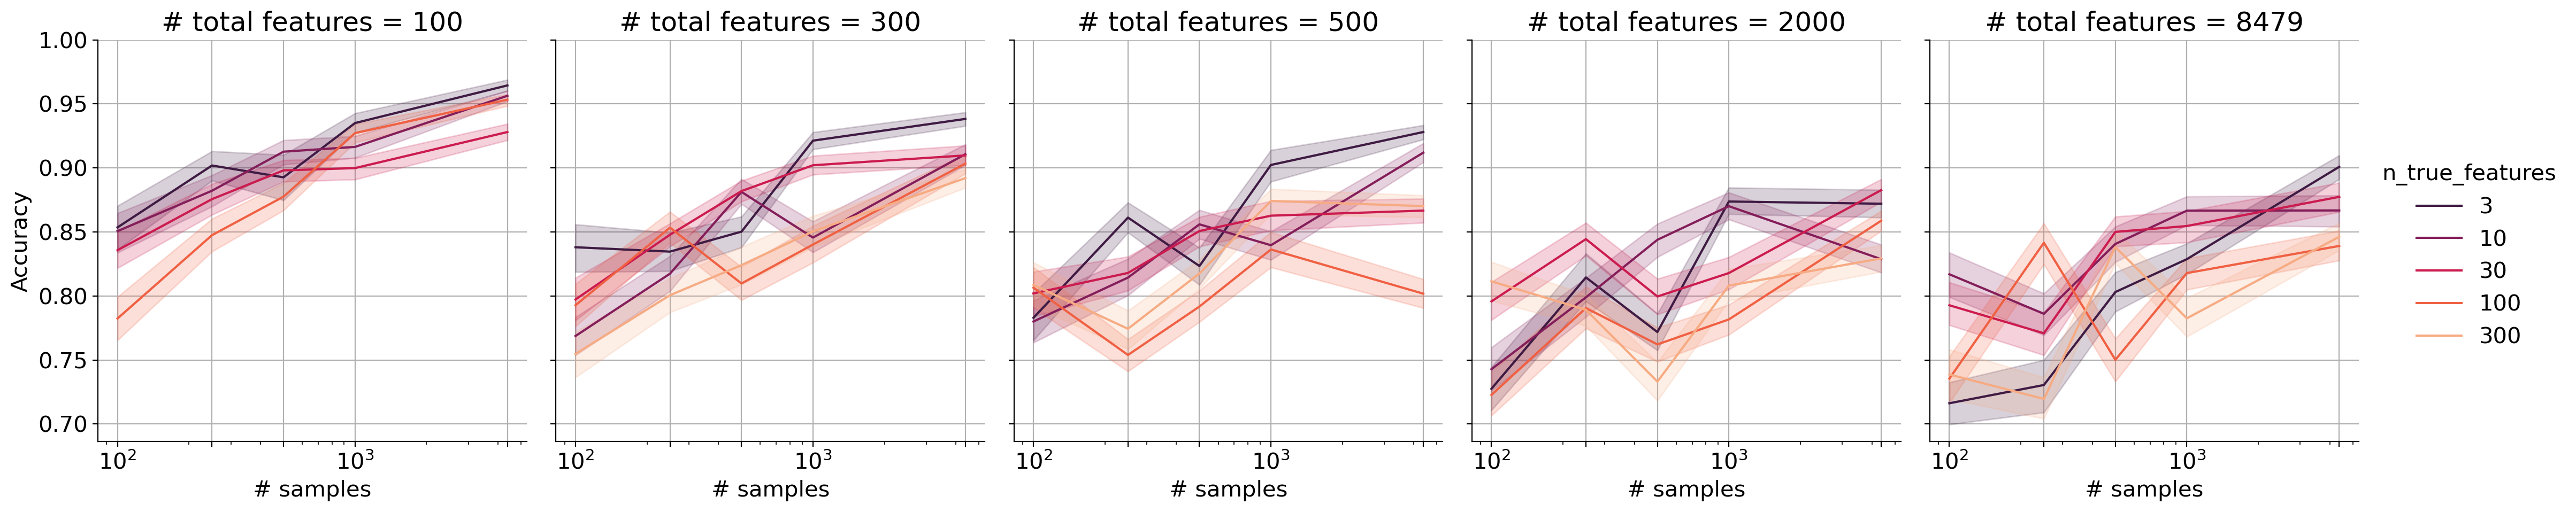

In [24]:
sns.relplot(data=df,
    x='n_samples',y='accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',
    height=5, aspect=0.9
    )

for ax in plt.gcf().get_axes():
    ax.grid()
    ax.semilogx()
    ax.set_ylim(top=1)
    ax.set_xticks(df['n_samples'].unique())
    ax.set_title(ax.get_title().replace('n_total_features = ', '# total features = '))
    ax.set_xlabel('# samples')
    ax.set_ylabel('Accuracy')


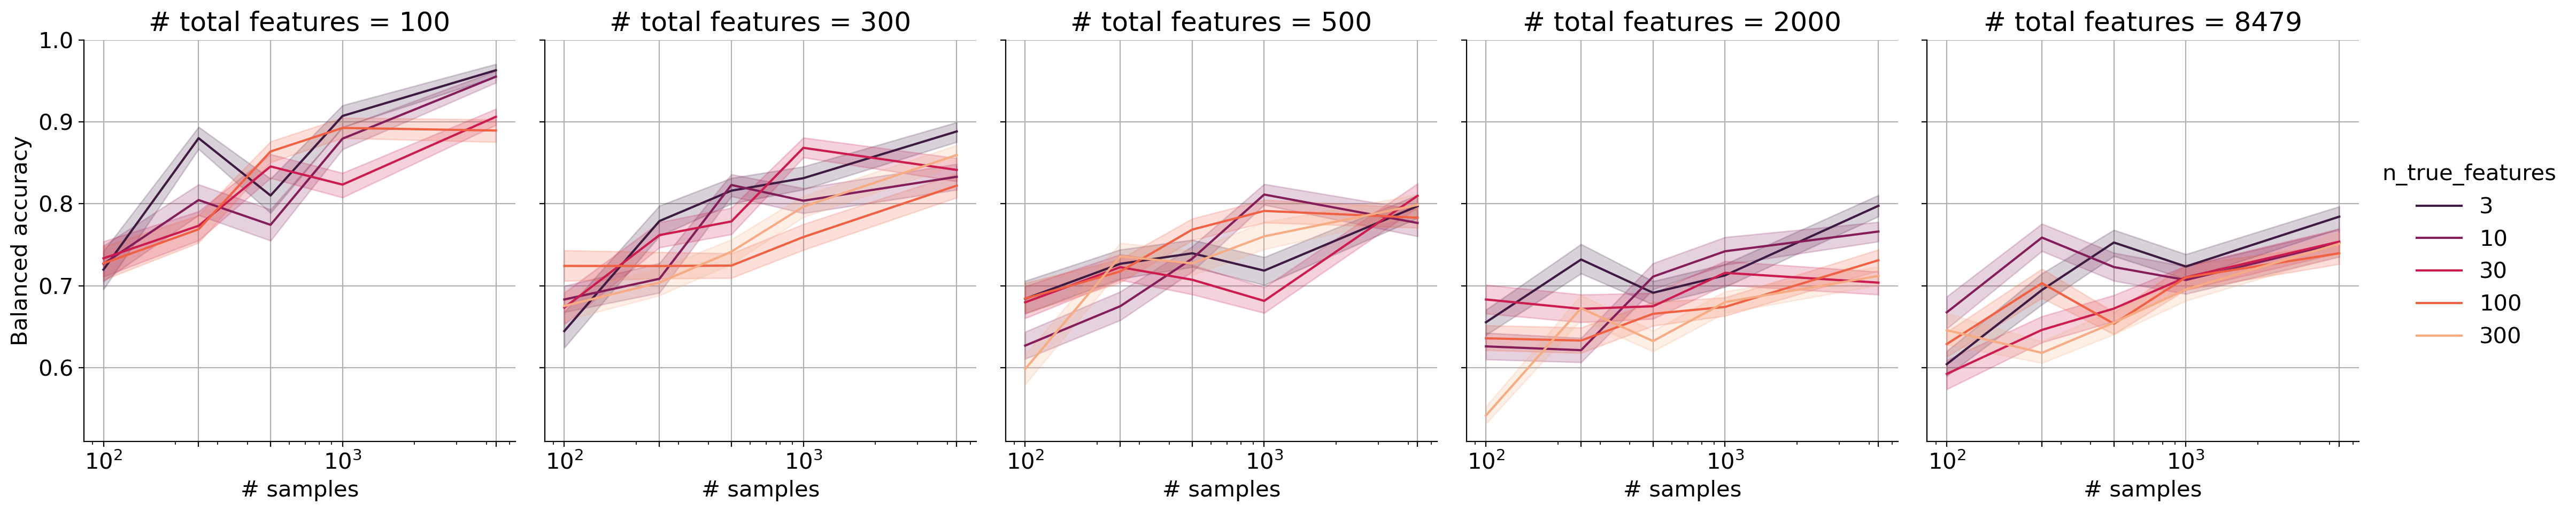

In [25]:
sns.relplot(data=df,
    x='n_samples',y='balanced_accuracy',hue='n_true_features',col='n_total_features',kind='line',palette='rocket',
    height=5, aspect=0.9
    )

for ax in plt.gcf().get_axes():
    ax.grid()
    ax.semilogx()
    ax.set_ylim(top=1)
    ax.set_xticks(df['n_samples'].unique())
    ax.set_title(ax.get_title().replace('n_total_features = ', '# total features = '))
    ax.set_xlabel('# samples')
    ax.set_ylabel('Balanced accuracy')


# Archive

### Plot

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
DIR_figure=f"{DIR_data}/figure_data/3B"

results_all=pd.read_pickle(f"{DIR_figure}/results_all.pk")

In [4]:
df=results_all[(results_all['min_split_ratio']==0) & (results_all['split_name']=='ooc') & (results_all['model_name'].isin(['RF','null']))]

stat=compare_models(df, [[('RF','null'),ttest]], seperate_by=['n_samples','n_total_features','n_true_features','carbon_name'], metric='accuracy',model_key='model_name')


  0%|          | 0/1200 [00:00<?, ?it/s]


TypeError: sequence item 0: expected str instance, tuple found

In [72]:
def plot_syn_results(df, metric='accuracy',  
                x_key=['n_samples'],y_key=['n_total_features'],
                axes_cols=['n_true_features'],axes_rows=['min_split_ratio','split_name','model_name'],
                figsize=(20,30),vmin=0,vmax=1): 
    # keys not specified in one of these parametes will be averaged over. E.g. carbon_name

    if axes_cols is None:
        axes_cols=[]
    if axes_rows is None:
        axes_rows=[]

    if vmin is None:
        vmin=df[metric].min()
    if vmax is None:
        vmax=df[metric].max()
    
    df=df.groupby(x_key+y_key+axes_cols+axes_rows)[metric].mean().reset_index()


    df['_ax_col_key']=''
    for ax_col in axes_cols:
        df['_ax_col_key']=df['_ax_col_key']+'_'+df[ax_col].astype(str)
    df['_ax_row_key']=''
    for ax_row in axes_rows:
        df['_ax_row_key']=df['_ax_row_key']+'_'+df[ax_row].astype(str)
    df=df.sort_values(by=['_ax_row_key','_ax_col_key'])
    fig, axes=plt.subplots(df['_ax_row_key'].nunique(),df['_ax_col_key'].nunique(),figsize=figsize,sharex=True,sharey=True)
    for ((ax_row_key,ax_col_key), sub_df),ax in tqdm(zip(df.groupby(['_ax_row_key','_ax_col_key']),np.array(axes).flatten())):
        sub_df=sub_df.pivot(index=x_key, columns=y_key, values=metric)
        sns.heatmap(sub_df, ax=ax, vmin=vmin, vmax=vmax, cmap='viridis')
        ax.set_title(ax_row_key+' '+ax_col_key)
    
    fig.tight_layout()

    

In [75]:
plot_syn_results(results_all[(results_all['min_split_ratio']==0) & (results_all['split_name']=='ooc') & (results_all['model_name'].isin(['RF']))],
            metric='accuracy',x_key=['n_samples'],y_key=['n_total_features'],axes_cols=['n_true_features'],axes_rows=None,figsize=(25,7),vmin=0.5,vmax=1)

5it [00:00, 13.45it/s]


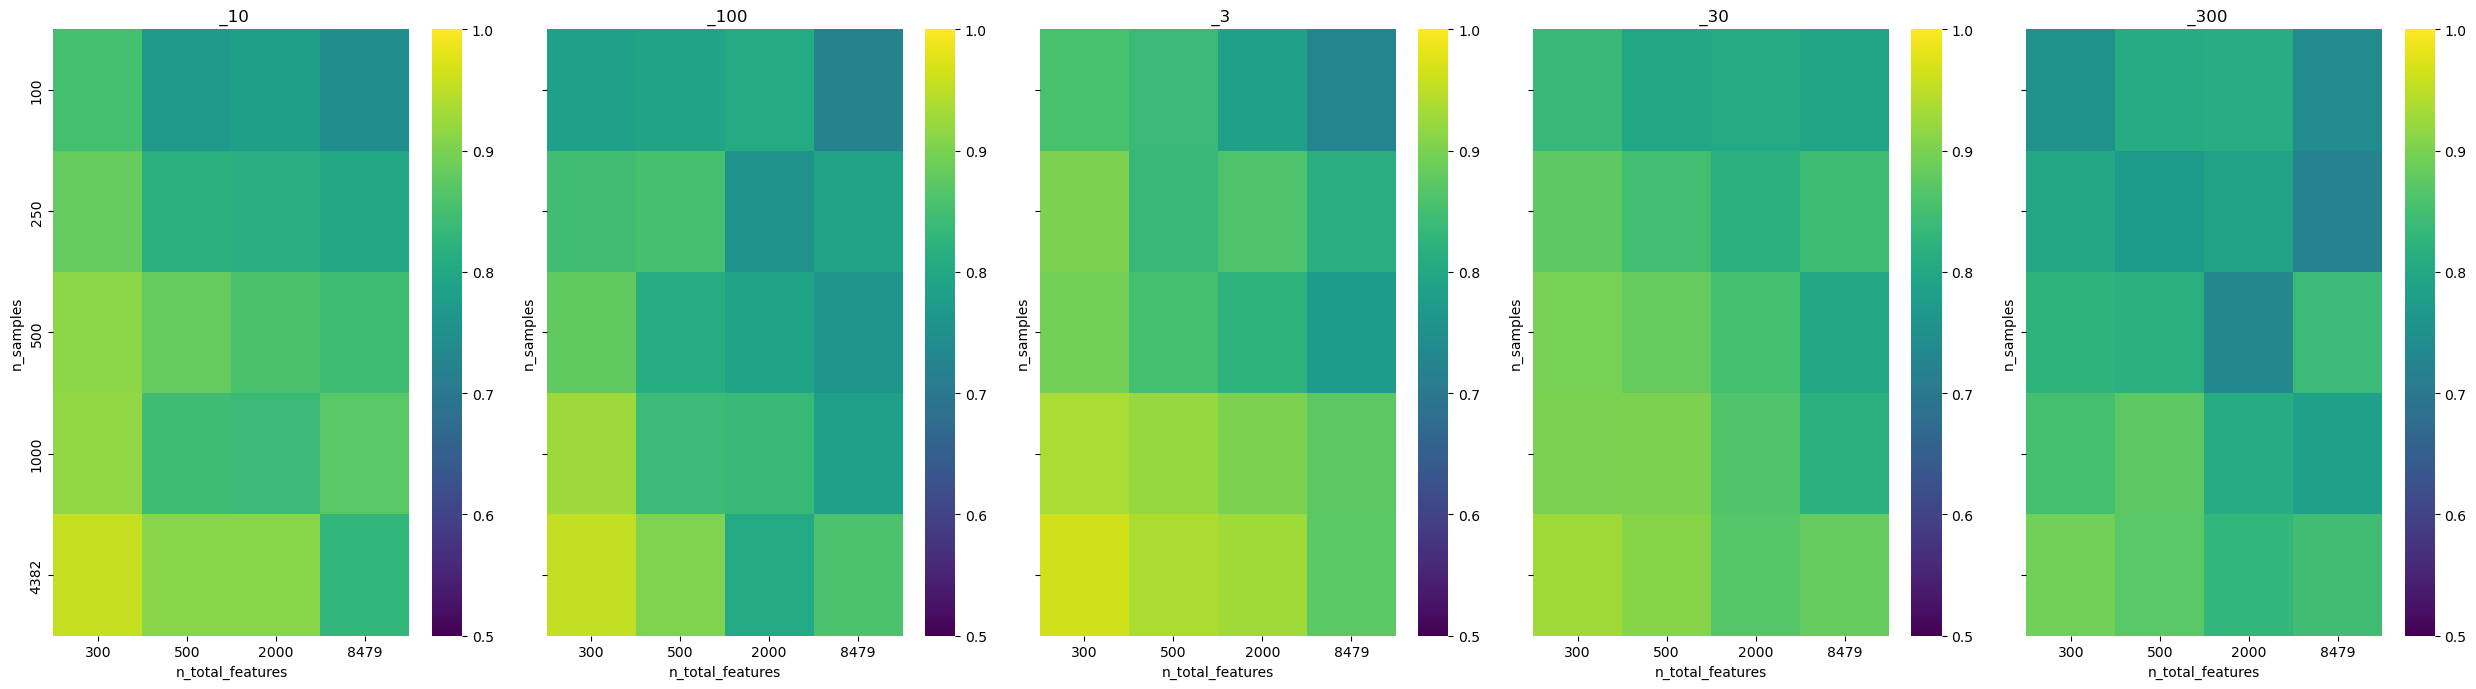

In [76]:
plt.gcf()

5it [00:00, 12.27it/s]


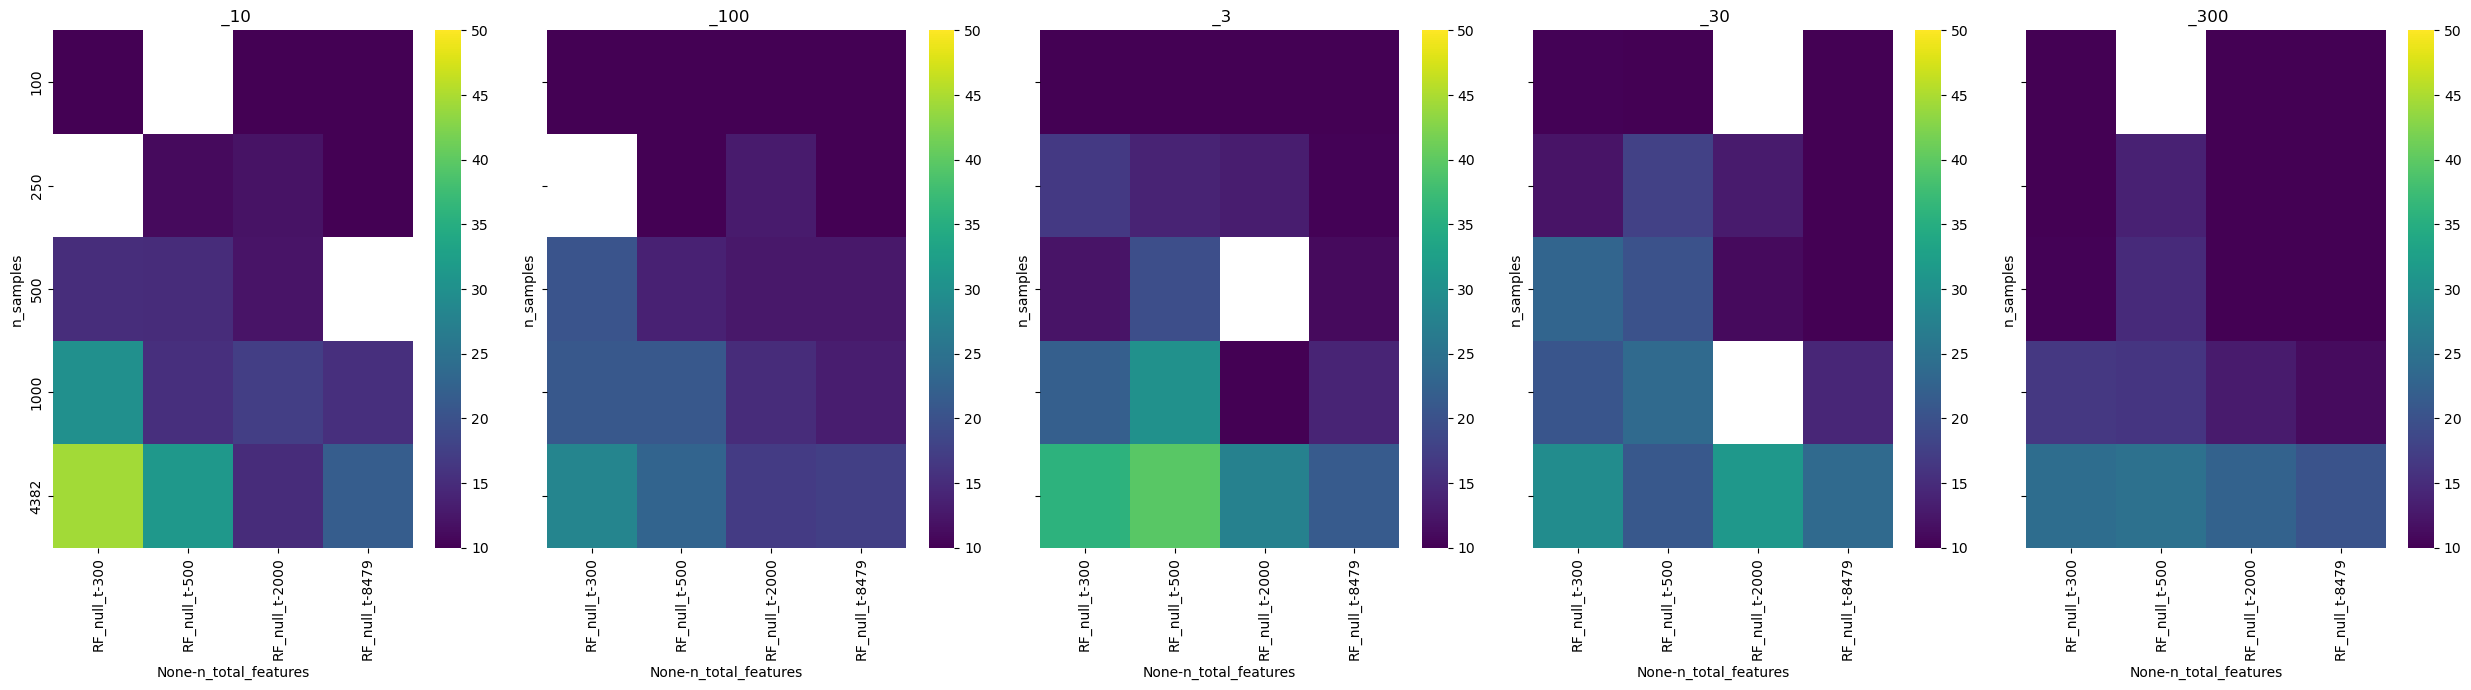

In [23]:
plot_syn_results(stat, metric=['RF_null_t'], x_key=['n_samples'],y_key=['n_total_features'],axes_cols=['n_true_features'],axes_rows=None,figsize=(25,7),vmin=10,vmax=50)

In [12]:
stat

stat,n_samples,n_total_features,n_true_features,carbon_name,RF_null_p,RF_null_significant,RF_null_t
0,100,100,3,sim_trait_0,0.0,True,9.514169
1,100,100,3,sim_trait_1,0.0,True,17.327907
2,100,100,3,sim_trait_2,0.009207,True,2.669454
3,100,100,3,sim_trait_3,0.049953,True,1.985341
4,100,100,3,sim_trait_4,0.0,True,5.553725
...,...,...,...,...,...,...,...
1195,4382,8479,300,sim_trait_5,0.0,True,10.945726
1196,4382,8479,300,sim_trait_6,0.0,True,20.540367
1197,4382,8479,300,sim_trait_7,0.0,True,7.017359
1198,4382,8479,300,sim_trait_8,0.0,True,25.04271


60it [00:34,  1.73it/s]


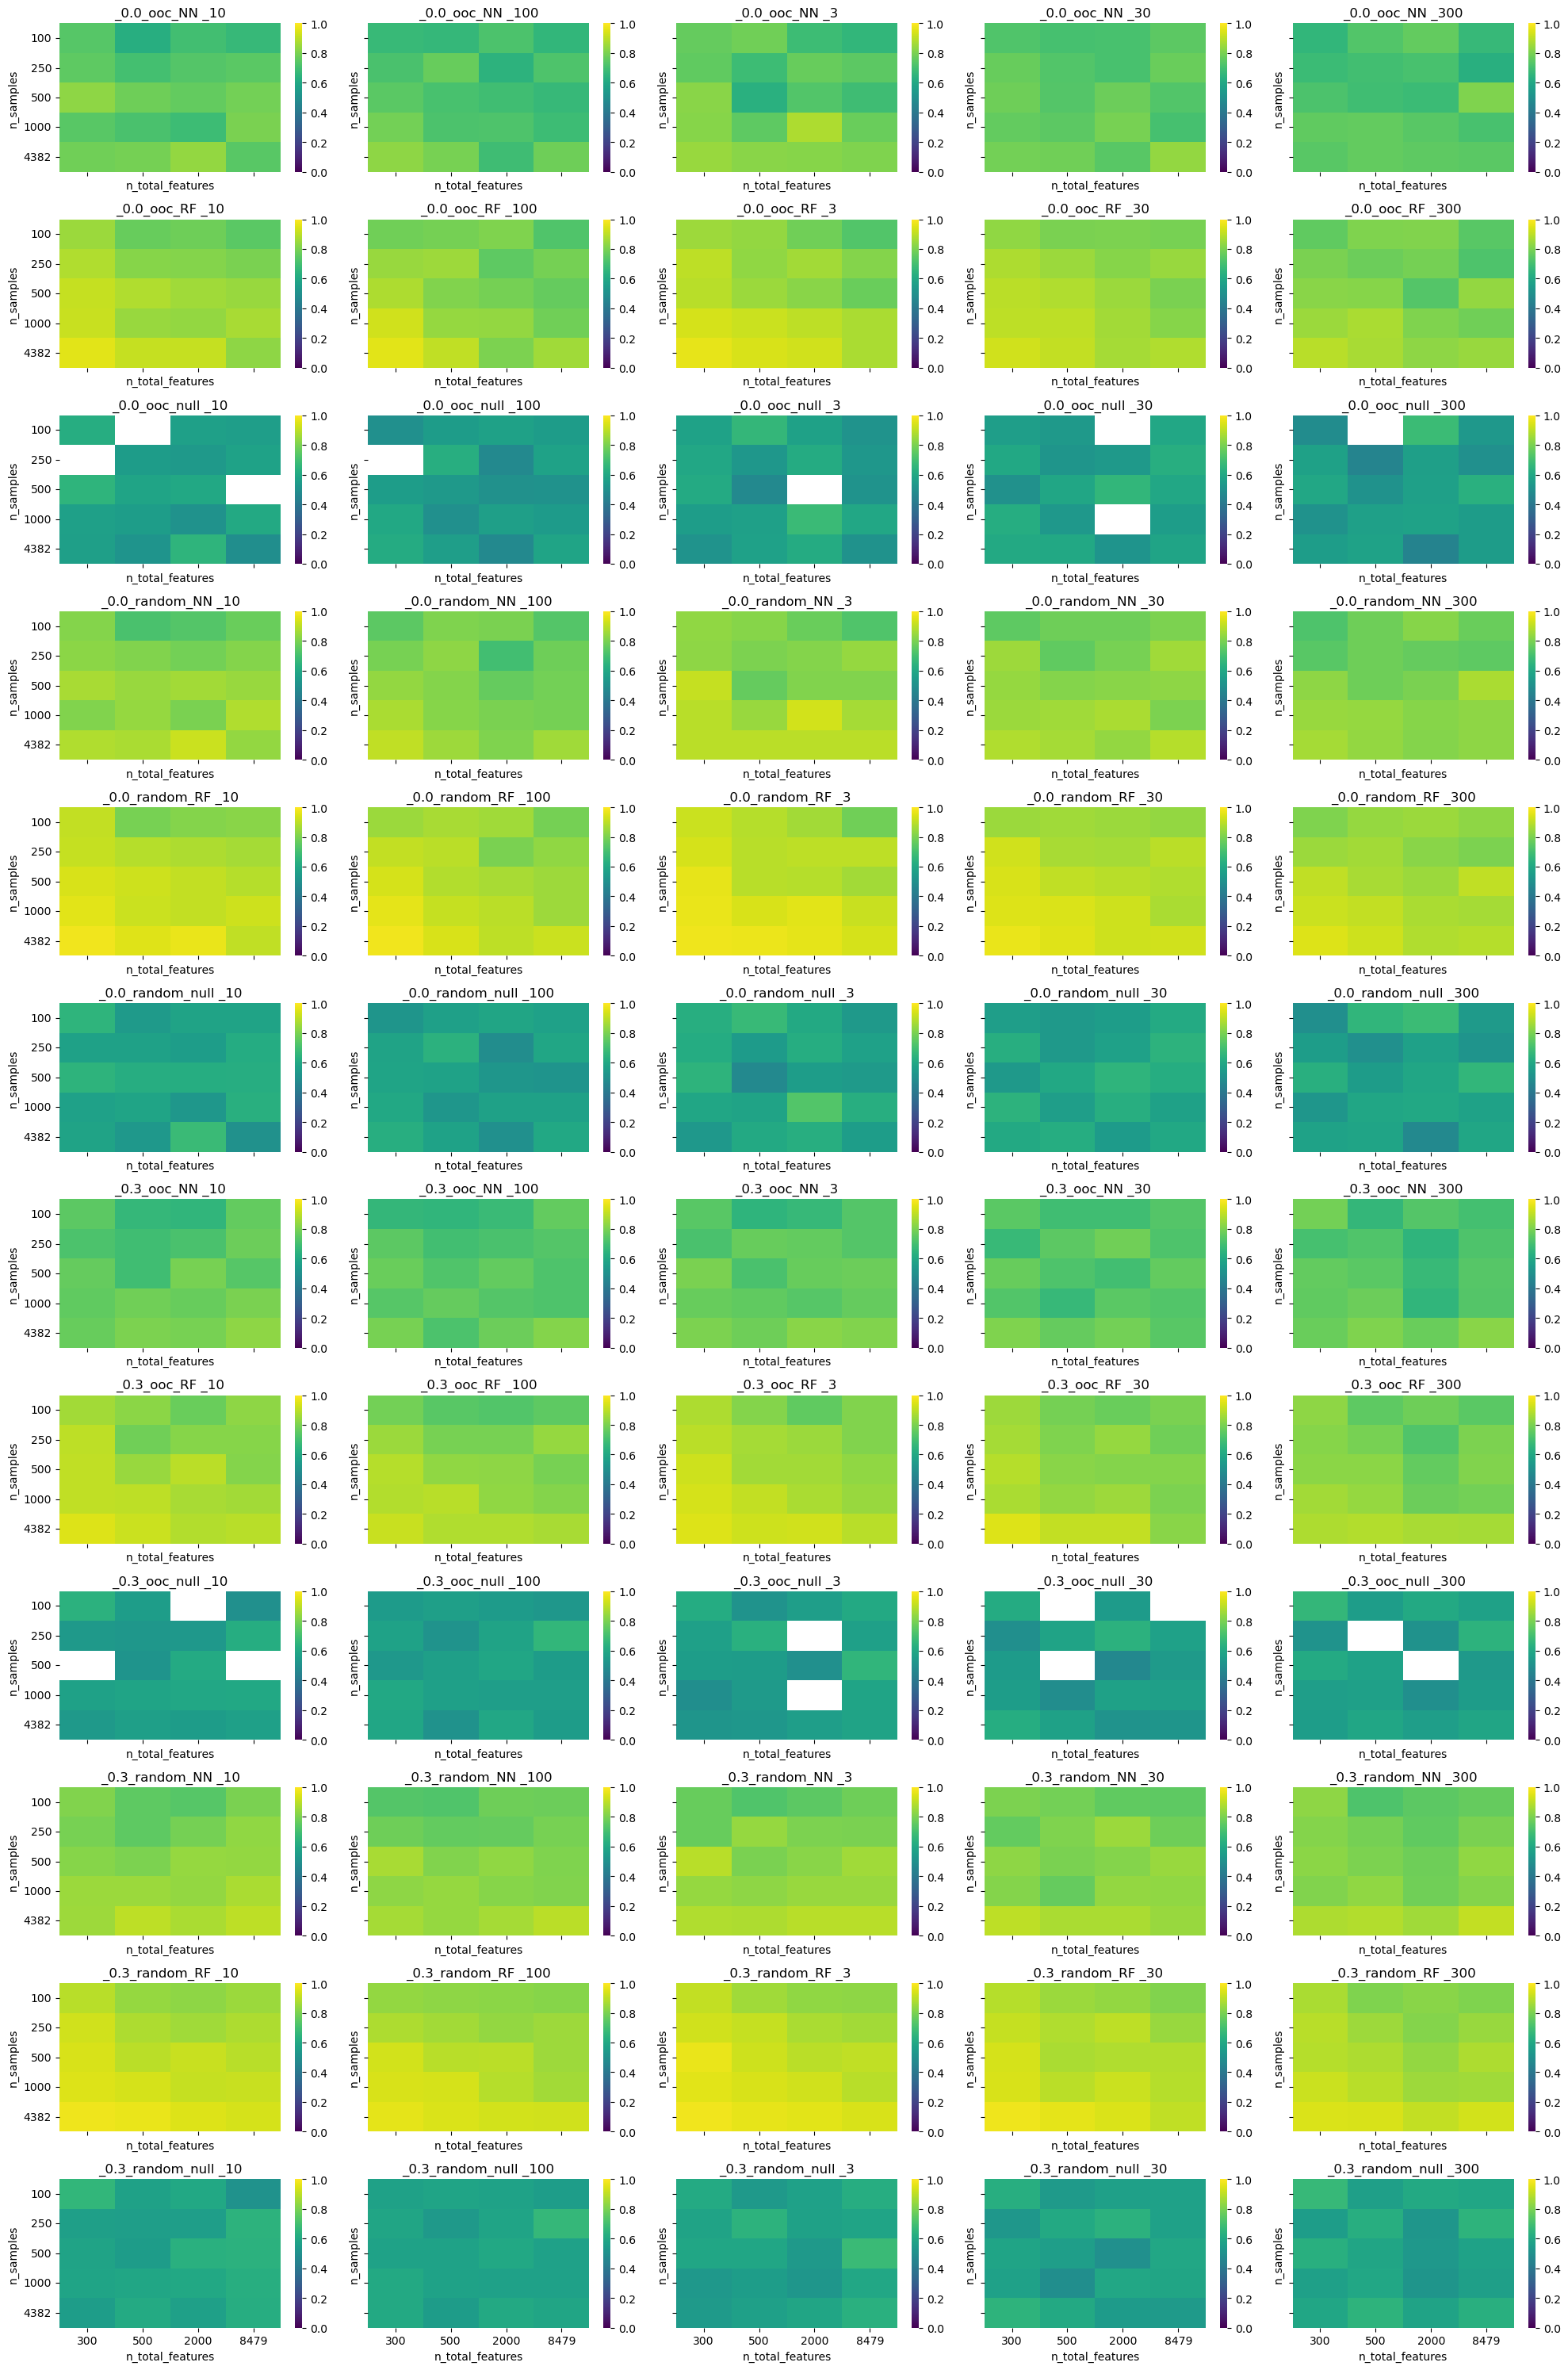

In [14]:
plot_syn_results(results_all, metric='accuracy')

In [ ]:
df=results_all[(results_all['min_split_ratio']>0.2) & (results_all['split_name']=='random') & (results_all['model_name']=='RF') & (results_all['n_true_features']==100)]
sns.heatmap(df.groupby(['n_samples','n_total_features'])['accuracy'].mean().reset_index().pivot('n_samples','n_total_features','accuracy'),vmin=0,vmax=1)

In [ ]:
DIR_results="/home/zeqianli/project/zeqianli/Kuehn/Carbon/bacdive_sim_phase_diagram_2/results"
DIR_data="/home/zeqianli/project/zeqianli/Kuehn/Carbon/bacdive_sim_phase_diagram_2/data"

In [ ]:
all_data={}

for ff in os.listdir(DIR_results):
    if not 'RF' in ff:
        continue
    try:
        data=pd.read_pickle(os.path.join(DIR_results,ff))
        if not isinstance(data, pd.DataFrame):
            continue
    except EOFError:
        continue
    print("Loaded ", ff)

    ff=ff.replace('.pk','').replace('sim_data_','')
    all_data[ff]=data

    


In [ ]:
all_data_raw={}
for ff in os.listdir(DIR_data):
    all_data_raw[ff.replace('.pk','').replace('sim_data_','')]=pd.read_pickle(os.path.join(DIR_data,ff))

In [ ]:
ffs=[]
for n_samples in [100,1000,4285]:
    for n_total_features in [100,1000,None]:
        for n_true_features in [3,10,100]:
            for split in ['random','ooc']:
                ffs.append(f'{n_samples}_{n_total_features}_{n_true_features}_RF_{split}')

## Accuracy

In [ ]:
# Plot 

fig, axes=plt.subplots(9,6, figsize=(6*4,9*4),sharey=True)
# plt.suptitle('nsample_nfeature_ntrue feature model_partition', )

for ff,ax in tqdm(zip(ffs,np.array(axes).flatten())):
    plot_prediction_accuracy(all_data[ff], ax=ax)
    ax.set_title(ff)
plt.tight_layout()

## Feature importance

In [3]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
DIR_figure=f"{DIR_data}/figure_data/3B"

results_all=pd.read_pickle(f"{DIR_figure}/results_all.pk")

In [14]:
group

,carbon_name,train_samples,test_samples,feature_importances,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,n_samples,n_total_features,n_true_features,min_split_ratio,model_name,split_name,is_null_model,null_model,replace,n_neighbors,weights,metric
685000,sim_trait_0,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[11175, 130292, 132221, 132257, 132550, 152406...","[0.007888441034169797, 0.015041790565318711, 0...",0,0,0,13,1.000000,1.0,1.000,NaN,1.000000,NaN,87,13,100,100,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
685001,sim_trait_0,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[12009, 1257, 12922, 13087, 13152, 13155, 1349...","[0.004469934288162346, 0.016848486082630114, 0...",6,0,0,4,1.000000,1.0,1.000,1.000000,1.000000,1.000000,90,10,100,100,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
685002,sim_trait_0,"[10473, 10474, 10494, 10496, 11113, 11148, 111...","[10622, 10655, 11367, 132285, 132756, 13370, 1...","[0.006659415456357961, 0.016742456909311195, 0...",0,1,0,9,0.900000,0.9,1.000,0.000000,0.947368,0.500000,90,10,100,100,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
685003,sim_trait_0,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[12581, 134301, 1629, 17838, 193, 24343, 3931,...","[0.015203928100280312, 0.016895459004550323, 0...",0,0,0,14,1.000000,1.0,1.000,NaN,1.000000,NaN,86,14,100,100,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
685004,sim_trait_0,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[134301, 14049, 1629, 166368, 17712, 24343, 56...","[0.012882408677441084, 0.01137688525097183, 0....",0,0,0,10,1.000000,1.0,1.000,NaN,1.000000,NaN,90,10,100,100,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
686495,sim_trait_9,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[130292, 132221, 132257, 132550, 132992, 15068...",NaN,5,1,7,1,0.428571,0.5,0.125,0.833333,0.200000,0.479167,86,14,100,100,3,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN
686496,sim_trait_9,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[130292, 132221, 132257, 132550, 132992, 15240...",NaN,4,0,8,0,0.333333,NaN,0.000,1.000000,NaN,0.500000,88,12,100,100,3,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN
686497,sim_trait_9,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[130600, 130622, 130637, 132898, 132948, 13647...",NaN,9,3,0,0,0.750000,0.0,NaN,0.750000,NaN,NaN,88,12,100,100,3,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN
686498,sim_trait_9,"[10473, 10474, 10494, 10496, 10622, 10655, 111...","[12760, 12922, 130292, 130501, 13087, 13152, 1...",NaN,6,0,10,0,0.375000,NaN,0.000,1.000000,NaN,0.500000,84,16,100,100,3,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN


In [20]:
fi_all=[]

df=results_all[(results_all['min_split_ratio']==0) & (results_all['split_name']=='ooc') & (results_all['model_name'].isin(['RF']))]

for (n_total_features, n_samples, n_true_features), group in tqdm(df.groupby(['n_total_features','n_samples','n_true_features'])):
    try:
        raw_data=pd.read_pickle(f"{DIR_figure}/synthetic_data/{n_samples}_{n_total_features}_{n_true_features}_0.pk")
        highlight={}
        for c in group['carbon_name'].unique():
            highlight[c]={'true_feature':raw_data['mechanism'].at[c,'true_features']}
        
        fi=cal_feature_importance(group, raw_data['ko_data'],highlight=highlight,trim=100)

        fi['n_total_features']=n_total_features
        fi['n_samples']=n_samples
        fi['n_true_features']=n_true_features
        fi_all.append(fi)
    except Exception as e:
        print(e)
        print(f"Failed: {n_samples}_{n_total_features}_{n_true_features}_0")

fi_all=pd.concat(fi_all,axis=0,ignore_index=True)
    

100%|██████████| 120/120 [00:41<00:00,  2.91it/s]


In [68]:
_keys=['carbon_name','n_total_features','n_samples','n_true_features']

def fi_metric(group):
    group=group.sort_values(by='fi_mean',ascending=False)
    arr=1/np.arange(1,len(group)+1)
    is_true_feature=(group['highlight']!='')
    N=min(len(is_true_feature), group['n_true_features'].iloc[0]*2)
    #return (arr * is_true_feature).sum()/arr[:group['n_true_features'].iloc[0]].sum()
    return is_true_feature.iloc[:N].sum()/group['n_true_features'].iloc[0]

fi_metric=fi_all.groupby(_keys).apply(fi_metric).reset_index().rename(columns={0:'fi_metric'})

fi_metric_mean=fi_metric.groupby(['n_total_features','n_samples','n_true_features'])['fi_metric'].mean().reset_index()

In [69]:
fi_metric

,carbon_name,n_total_features,n_samples,n_true_features,fi_metric
0,sim_trait_0,100,100,3,0.333333
1,sim_trait_0,100,100,10,0.200000
2,sim_trait_0,100,100,30,0.533333
3,sim_trait_0,100,100,100,1.000000
4,sim_trait_0,100,250,3,1.000000
...,...,...,...,...,...
1195,sim_trait_9,8479,4382,3,0.666667
1196,sim_trait_9,8479,4382,10,0.100000
1197,sim_trait_9,8479,4382,30,0.100000
1198,sim_trait_9,8479,4382,100,0.030000


In [47]:
group.pivot('n_samples','n_total_features')['fi_metric']

/home/zeqianli/ipykernel_1777847/1616655590.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  group.pivot('n_samples','n_total_features')['fi_metric']


n_total_features,100,300,500,2000,8479
n_samples,,,,,
100,0.549984,0.503329,0.419352,0.388108,0.264378
250,0.566051,0.509327,0.466827,0.408315,0.280024
500,0.674323,0.480765,0.538310,0.439028,0.368565
1000,0.685143,0.518179,0.550433,0.426804,0.271950
4382,0.643330,0.580381,0.548064,0.537307,0.372319


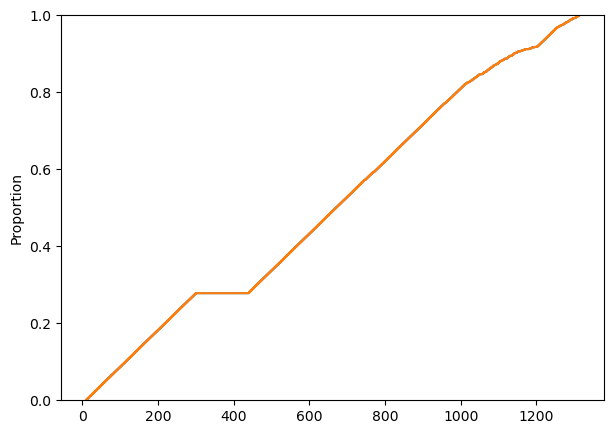

In [11]:
sns.ecdfplot(results_all[results_all['split_name']=='ooc']['test_samples'].str.len().unique())
plt.gcf()

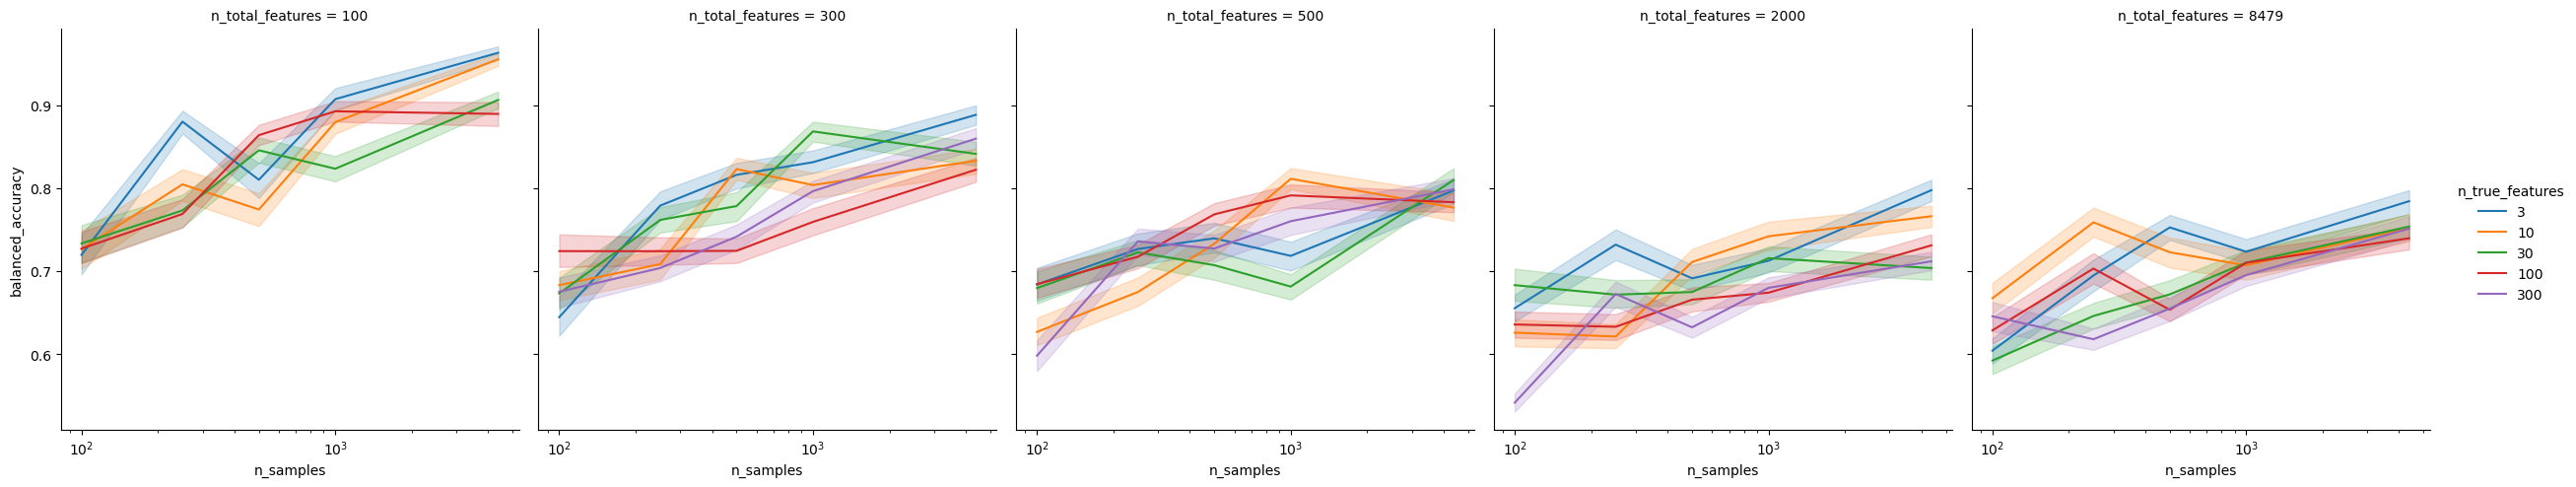

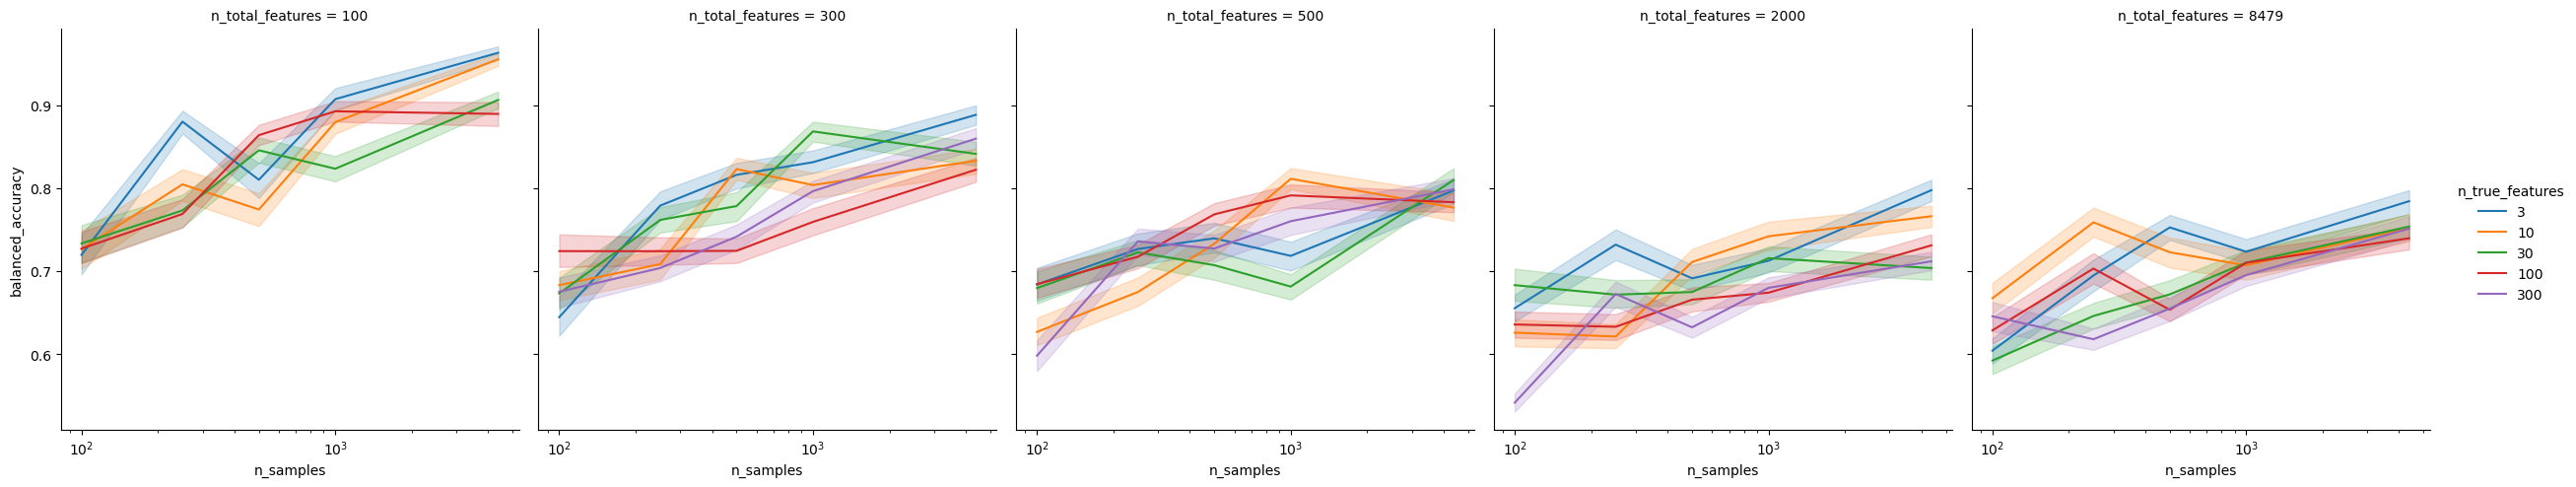

In [5]:
sns.relplot(data=results_all[(results_all['min_split_ratio']==0) & (results_all['split_name']=='ooc') & (results_all['model_name'].isin(['RF']))].astype({'n_true_features':str}),
        x='n_samples',y='balanced_accuracy',hue='n_true_features',col='n_total_features',kind='line')

plt.gca().semilogx()

plt.gcf()

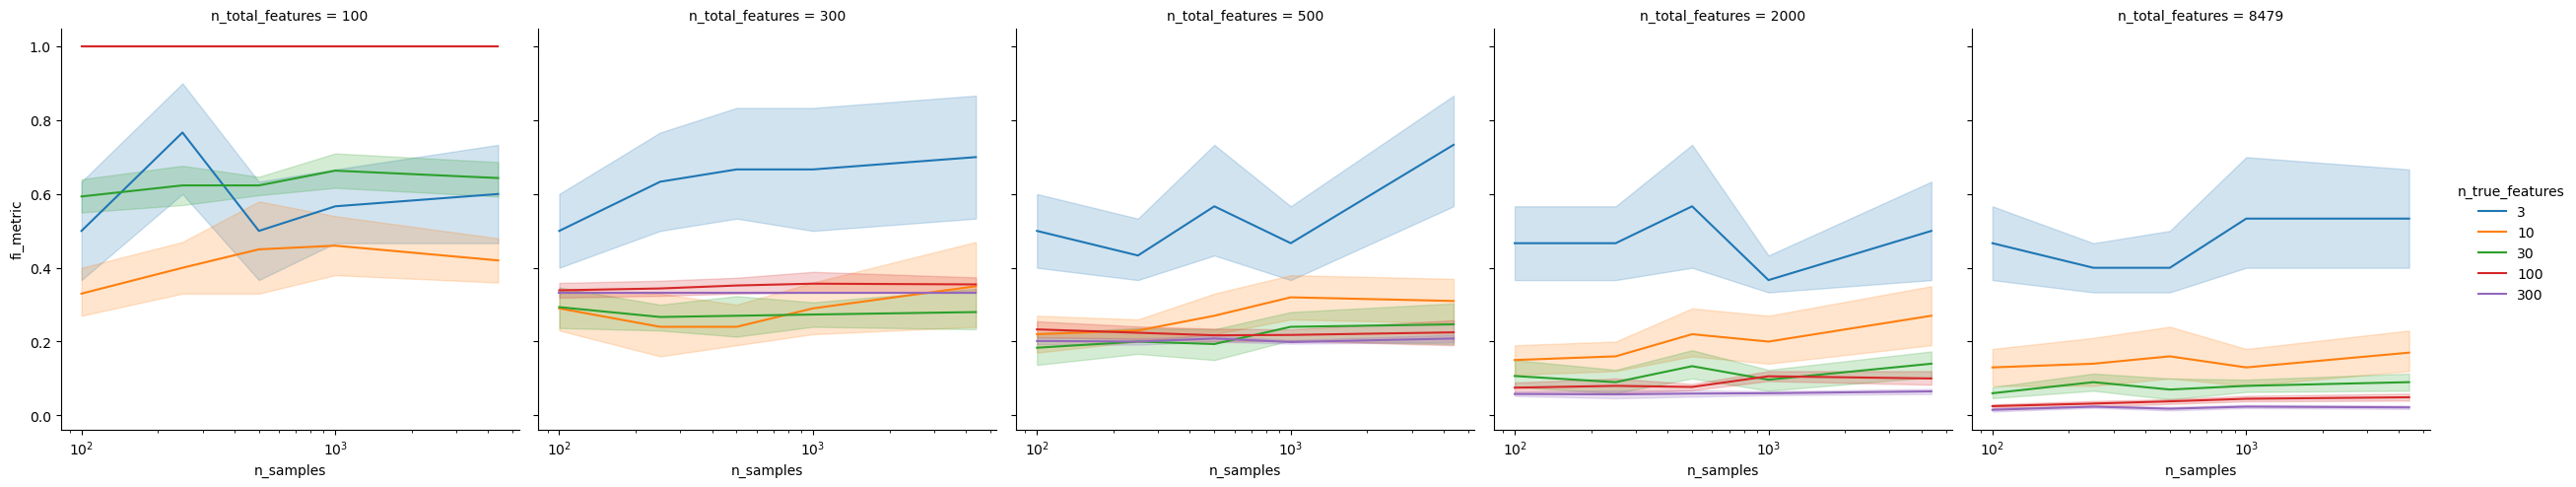

In [ ]:
sns.relplot(data=fi_metric.astype({'n_true_features':str}),x='n_samples',y='fi_metric',hue='n_true_features',col='n_total_features',kind='line')

plt.gca().semilogx()

plt.gcf()

In [71]:
raw=pd.read_pickle("/home/zeqianli/project/zeqian/Carbon/data/figure_data/3B/synthetic_data/100_8479_3_0.pk")
s

In [ ]:
raw_

In [ ]:
raw['ko_data']

In [58]:
6/11

0.5454545454545454

/home/zeqianli/ipykernel_1777847/1401965111.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(group.pivot('n_samples','n_total_features')['fi_metric'],ax=ax,vmin=0,vmax=1)
/home/zeqianli/ipykernel_1777847/1401965111.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(group.pivot('n_samples','n_total_features')['fi_metric'],ax=ax,vmin=0,vmax=1)
/home/zeqianli/ipykernel_1777847/1401965111.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(group.pivot('n_samples','n_total_features')['fi_metric'],ax=ax,vmin=0,vmax=1)
/home/zeqianli/ipykernel_1777847/1401965111.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(group.pivot('n_samples','n_total_features')['fi_metric'],ax=ax,vmin=0,vmax=1)
/home/zeqianli/ipykernel_1777847

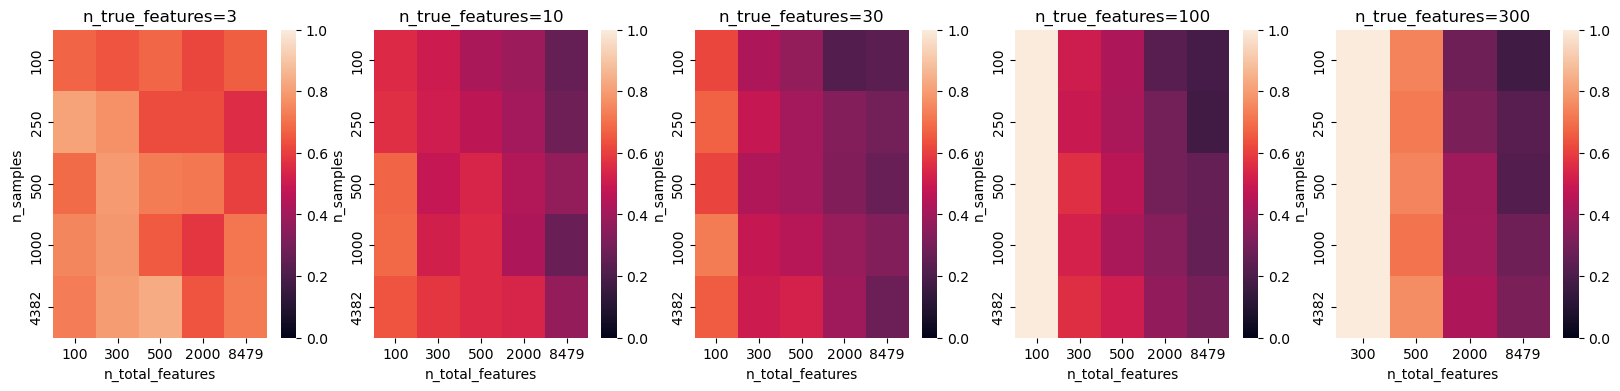

In [50]:
fig, axes=plt.subplots(1,fi_metric_mean['n_true_features'].nunique(), figsize=(4*fi_metric_mean['n_true_features'].nunique(),4))

for (n_true_features, group),ax in zip(fi_metric_mean.groupby('n_true_features'),axes):
    sns.heatmap(group.pivot('n_samples','n_total_features')['fi_metric'],ax=ax,vmin=0,vmax=1)
    ax.set_title(f'n_true_features={n_true_features}')
    ax.set_ylabel('n_samples')
    ax.set_xlabel('n_total_features')

fig


In [42]:
fi_metric_mean

,n_total_features,n_samples,n_true_features,fi_metric
0,100,100,3,0.675540
1,100,100,10,0.549984
2,100,100,30,0.616324
3,100,100,100,1.000000
4,100,250,3,0.813044
...,...,...,...,...
115,8479,4382,3,0.719972
116,8479,4382,10,0.372319
117,8479,4382,30,0.276029
118,8479,4382,100,0.299756


In [28]:
sns.relplot(data=fi_all[fi_all['carbon_name']=='sim_trait_0'],x='n_samples',y='fi_mean',hue='highlight',col='n_true_features',row='n_total_features',sharey=False)

AttributeError: PathCollection.set() got an unexpected keyword argument 'sharey'

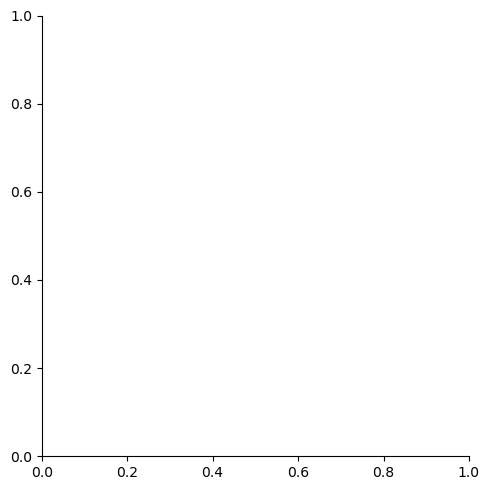

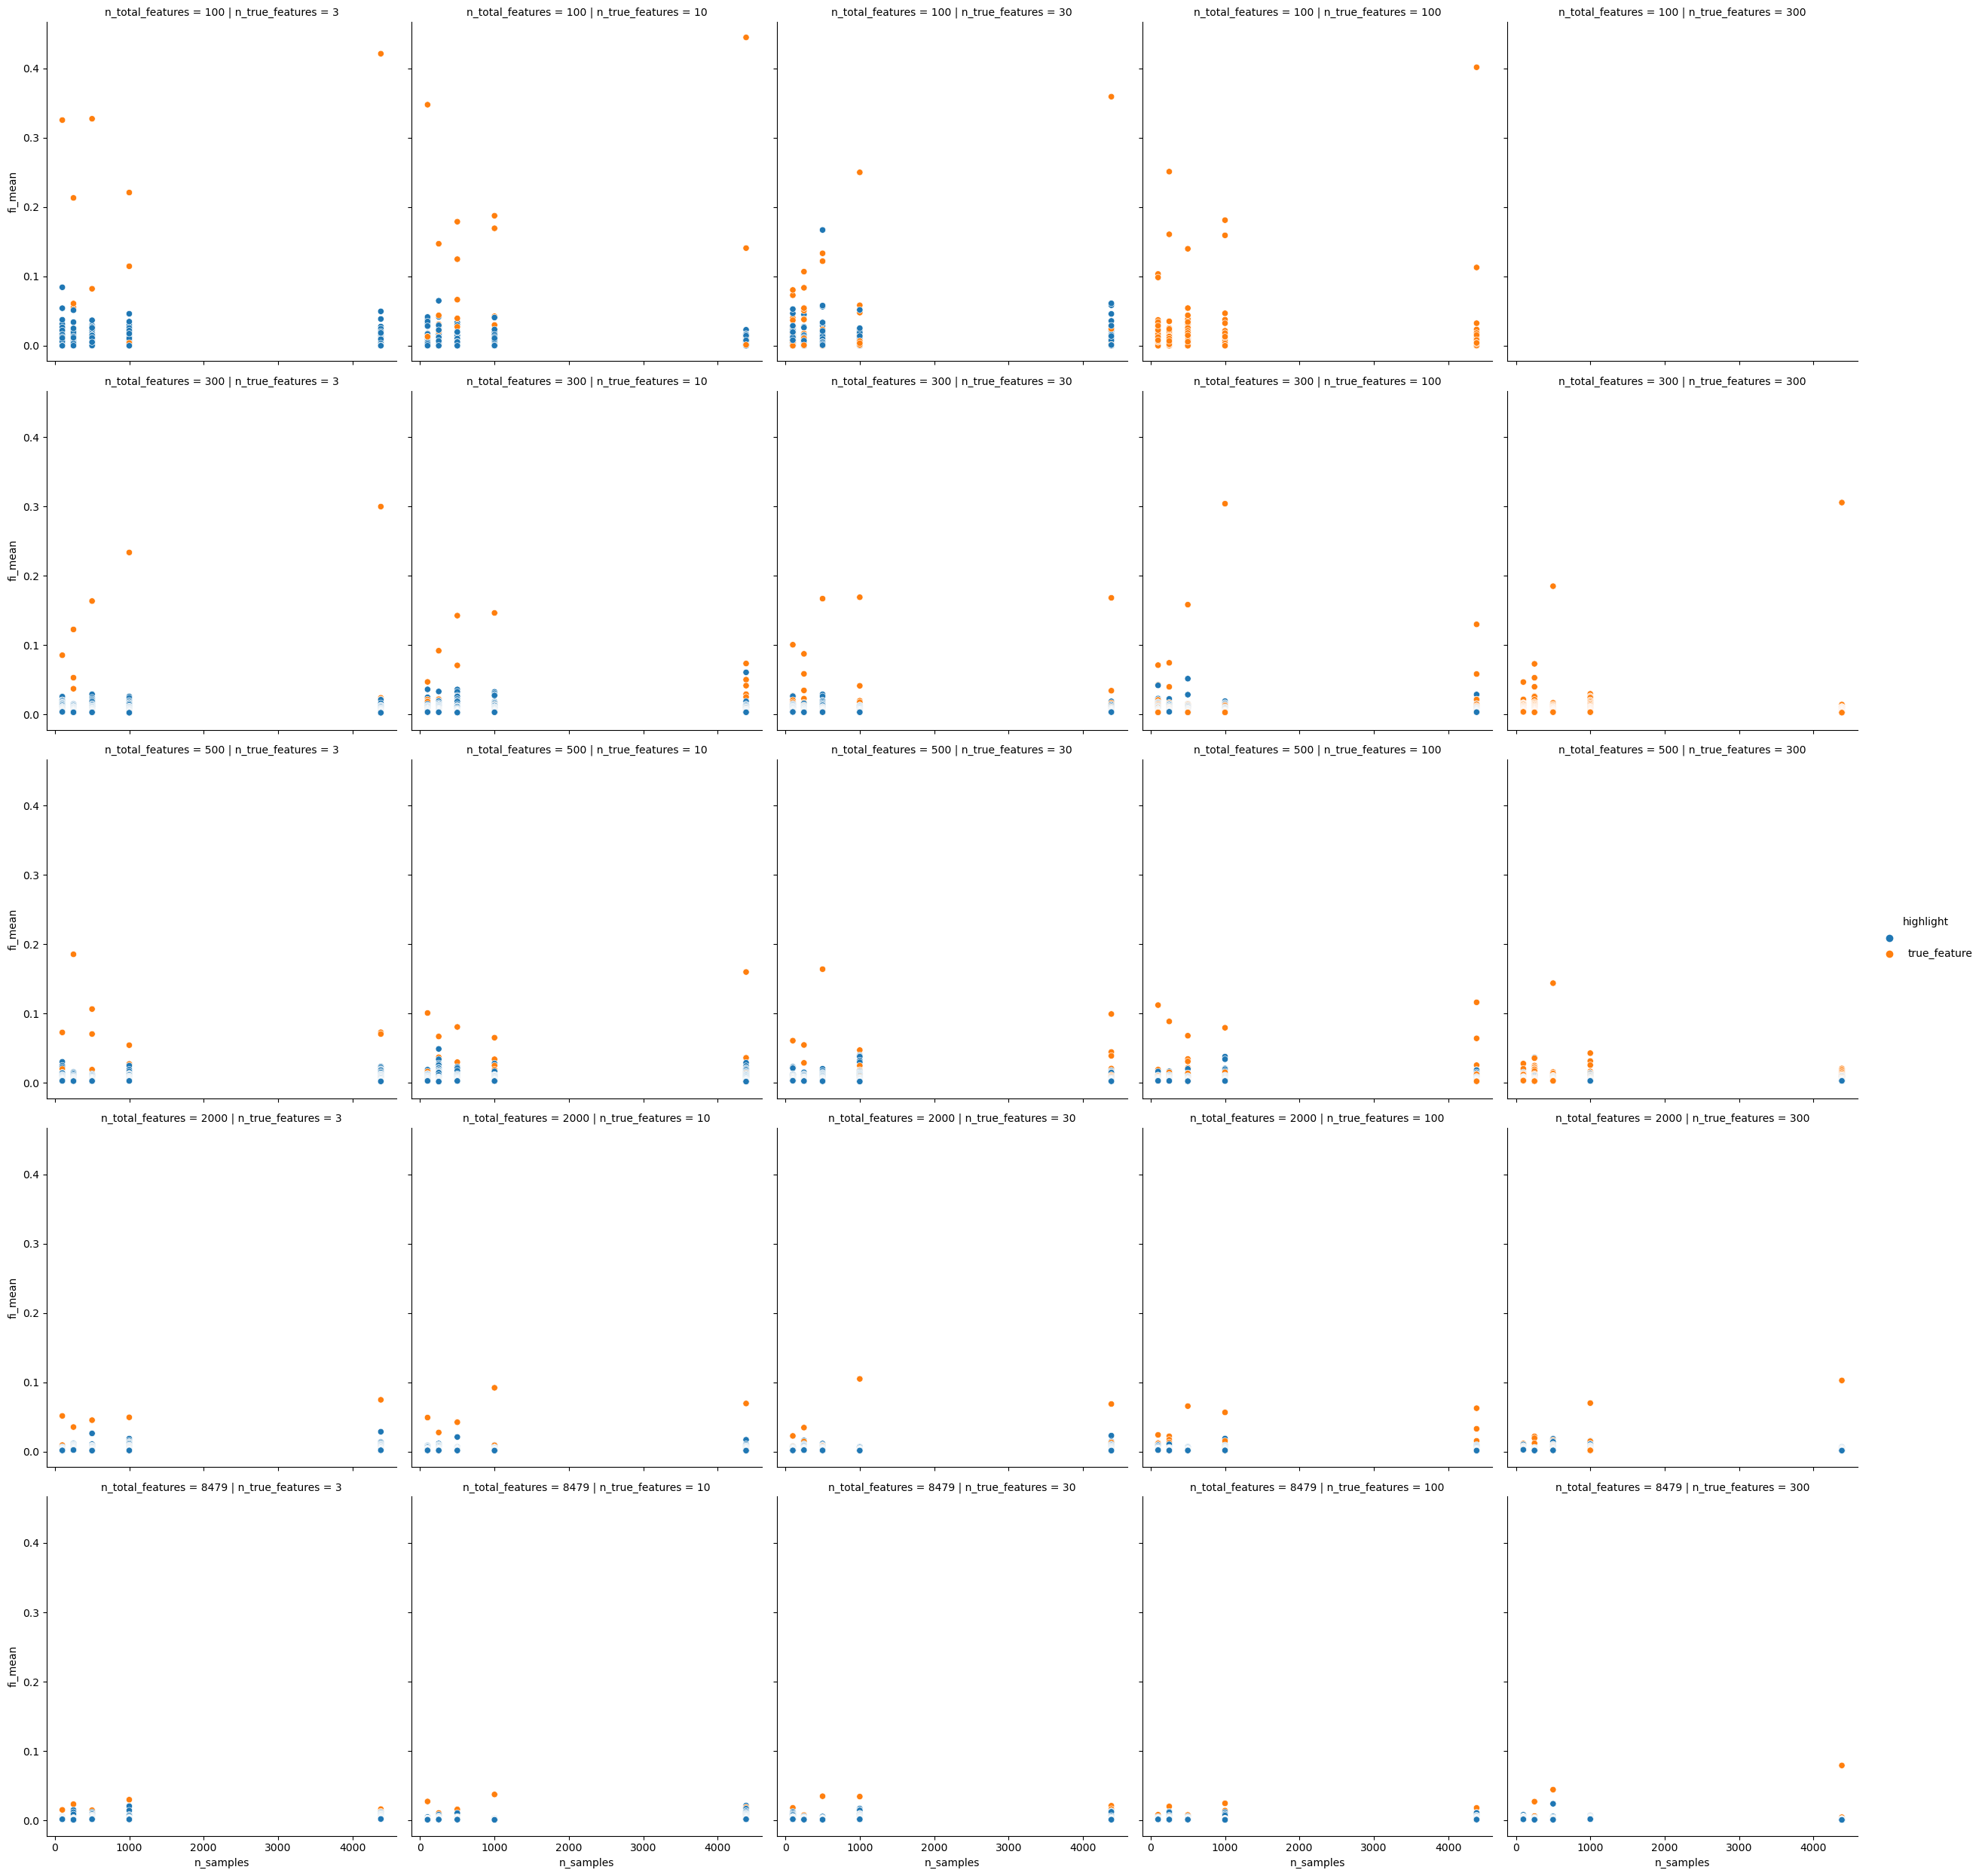

In [27]:
plt.show()

In [18]:
fi

,index,features,carbon_name,fi_mean,fi_std,highlight,n_total_features,n_samples,n_true_features
0,0,K22311,sim_trait_0,0.010080,0.005375,,100,100,3
1,1,K00248,sim_trait_0,0.017023,0.004700,,100,100,3
2,2,K14742,sim_trait_0,0.325259,0.036792,true_feature,100,100,3
3,3,K11739,sim_trait_0,0.000604,0.000718,,100,100,3
4,4,K20960,sim_trait_0,0.000264,0.000434,,100,100,3
...,...,...,...,...,...,...,...,...,...
995,95,K15829,sim_trait_9,0.011848,0.009116,,100,100,3
996,96,K14368,sim_trait_9,0.000000,0.000000,,100,100,3
997,97,K01512,sim_trait_9,0.031158,0.011784,true_feature,100,100,3
998,98,K19506,sim_trait_9,0.000000,0.000000,,100,100,3


In [10]:
df

,carbon_name,train_samples,test_samples,feature_importances,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,n_samples,n_total_features,n_true_features,min_split_ratio,model_name,split_name,is_null_model,null_model,replace,n_neighbors,weights,metric
500,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.0003193150145963178, 3.679912788604029e-05,...",525,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3854,528,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
501,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[11861, 11862, 11865, 11871, 11872, 11880, 118...","[0.0001108717439924443, 3.491512673068452e-05,...",365,2,107,50,0.778810,0.961538,0.318471,0.994550,0.478469,0.656511,3844,538,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
502,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[10485, 1102, 1120, 11401, 11421, 11423, 11439...","[7.090548069806474e-05, 3.723471690012371e-05,...",601,8,50,20,0.914706,0.714286,0.285714,0.986864,0.408163,0.636289,3702,680,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
503,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[11676, 11679, 11680, 11681, 11682, 11683, 116...","[0.00038250048823488023, 0.0001088771086569169...",463,0,0,3,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3916,466,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
504,sim_trait_0,"[10173, 10174, 10430, 10433, 10434, 10447, 104...","[10542, 10548, 10559, 10578, 10579, 10580, 105...","[0.0002897106583471398, 0.00010570692325179664...",28,14,0,576,0.963434,0.976271,1.000000,0.666667,0.987993,0.833333,3753,629,4382,8479,3,0.0,RF,ooc,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704495,sim_trait_9,"[10434, 10475, 10596, 10998, 11046, 11326, 116...","[13647, 13648, 17407, 22963, 2319, 2321, 23811...",NaN,5,4,2,1,0.500000,0.200000,0.333333,0.555556,0.250000,0.444444,88,12,100,100,100,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN
704496,sim_trait_9,"[10434, 10475, 10596, 10998, 11046, 11326, 116...","[12866, 12982, 130582, 13126, 13133, 132632, 1...",NaN,4,3,3,1,0.454545,0.250000,0.250000,0.571429,0.250000,0.410714,89,11,100,100,100,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN
704497,sim_trait_9,"[10434, 10475, 10596, 10998, 11046, 11326, 117...","[11603, 11966, 1261, 1300, 132033, 132445, 224...",NaN,1,5,2,1,0.181818,0.166667,0.333333,0.166667,0.222222,0.250000,89,11,100,100,100,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN
704498,sim_trait_9,"[10434, 10475, 10596, 10998, 11046, 11326, 117...","[11603, 11966, 1261, 1300, 131425, 132033, 132...",NaN,10,8,6,1,0.407407,0.111111,0.142857,0.555556,0.125000,0.349206,73,27,100,100,100,0.0,null,ooc,True,bernoulli,True,NaN,NaN,NaN


In [9]:
raw_data['mechanism']

,logic_object,logic_str,true_features
sim_trait_0,K19761|(K14742|K11016),K19761|(K14742|K11016),"[K19761, K11016, K14742]"
sim_trait_1,K01473|(K02043&K22311),K01473|(K02043&K22311),"[K22311, K01473, K02043]"
sim_trait_2,(K02478&K02622)|K11145,(K02478&K02622)|K11145,"[K02622, K11145, K02478]"
sim_trait_3,(K07477|K09911)|K21006,(K07477|K09911)|K21006,"[K07477, K09911, K21006]"
sim_trait_4,(K18538|K16389)|K12216,(K18538|K16389)|K12216,"[K16389, K12216, K18538]"
...,...,...,...
sim_trait_95,K16181|(K12941|K02478),K16181|(K12941|K02478),"[K12941, K02478, K16181]"
sim_trait_96,K22110|(K12567&K20023),K22110|(K12567&K20023),"[K12567, K20023, K22110]"
sim_trait_97,(K12941&K02201)|K06956,(K12941&K02201)|K06956,"[K02201, K06956, K12941]"
sim_trait_98,K12941|(K09690|K16192),K12941|(K09690|K16192),"[K16192, K09690, K12941]"


In [ ]:

fig, axes=plt.subplots(9,6, figsize=(6*4,9*4),sharey=True)

for ff,ax in tqdm(zip(ffs,np.array(axes).flatten())):
    data_raw=all_data_raw[ff.replace('_RF','').replace('_random','').replace('_ooc','')]
    df_fi=cal_feature_importance(all_data[ff], data_raw['kos_data'],data_raw['mechanism'],trim=100)
    sns.scatterplot(data=df_fi, x='fi_mean',y='carbon_name', hue='is_true_feature', size='fi_std',ax=ax,legend=False)
    ax.grid()
    ax.set_title(ff)

plt.tight_layout()


In [ ]:
sim_data['mechanism']

Plot trait correlation with the features. 

In [ ]:
trait='sim_trait_1'
ind=np.where(np.isin(data['kos_data'].columns,data['mechanism'].at[trait,'features']))[0]

sns.heatmap(pd.concat([data['kos_data'].iloc[:,ind],data['growth_data'].loc[:,[trait]]],axis=1))

Now the simualted trait can be mostly explained by a single gene. 

Implement parathesis in the logic chain. 